# 主成份分析 Principal component analysis （PCA）

我們先假設一個目的，我們現在就是要減少資料的維度，請看下面三張圖

![PCA-1](../../../images/pca-1.drawio.png)
![PCA-2](../../../images/pca-2.drawio.png)
![PCA-3](../../../images/pca-3.drawio.png)


假設在二維空間有三筆資料，我們想要壓縮到一維，你會設想怎麼做?



根據上面的圖片，假設 $X=\{x_1=(3,3), x_2=(-1,-2), x_3=(-2,-1)\}$，
我們用 $\bar{x}_i$ 表示 $x_i$ 的投影，
我們當然會希望投影以後的 variance 越大越好，
如果投影到 x 軸，
$\bar{x}_1=(3,0), \bar{x}_2=(-1,0), \bar{x}_3=(-2,0)$，我們會開始思考這投影足夠好嗎?

然後我們可以考慮投影到某個單位向量 $v=(v_1, v_2)$，

$$
\bar{x}_i = <x_i, v>v
$$

那他的 variance 是

$$
\Big( (3v_1+3v_2)^2 + (-v_1-2v_2)^2 + (-2v_1-1v_2)^2 \Big) \Big/ 3, v_1^2 + v_2^2 = 1 
$$

喔！我們就會發現，其實我們要求的就是有限制條件的求極值問題，這時候微積分的Lagrange就跳出來說我會解。




那我們把上面的問題一般化，假設有資料

$$
X = \{x_1, x_2, \cdots, x_n\}
$$

資料的 $X$ 的平均是 $\bar{x}$，為了方便理解我們假設是 0，
我們可以知道對於向量 $v$ 的投影是

$$
\{<v,x_1> v, <v,x_2> v, \cdots, <v,x_n> v\}
$$

我們可以算出投影後的變異數

$$
\sigma^2 = \frac{1}{n} \sum_{i=1}^n(v^Tx_i)^2 = v^T C v
$$

其中 $C$ 是共變異矩陣（covariance matrix）

$$
C = \frac{1}{n} \sum_{i=1}^n x_i x_i^T = \frac{1}{n} X X^T
$$

所以我們的問題就變成

$$
\argmax_v v^T C v, \|v\|=1
$$

另 

$$
f(v, \lambda) = v^T C v - \lambda (\|v\| - 1)
$$ 

對 $v$ 偏微分可以得到

$$
C v = \lambda v
$$

對 $\lambda$ 偏微分可以得到

$$
\|v\|=1
$$

然後我們就發現原來要解的問題是求

$$
C=\frac{1}{n} X X^T
$$

矩陣的特徵值 （eigenvalue），對應到要投影的向量就是 eigenvector，
但是常常 $X$ 數量是非常多的，
所以會用 SVD 分解快速求出 $C$ 的 eigenvalue 跟 eigenvector。



下面列出 PCA 的步驟

* 平移到資料 $X$ 中心
* 對平移後的矩陣 $X$ 算 SVD （singular value decomposition）分解
* 求出 $C$ 的 eigenvalue 跟 eigenvector


下面會介紹 PCA, Incremental PCA 的使用方法，
Incremental PCA 跟 PCA 在想法上面是一樣的，
他想解決的是工程上的問題，就是如果你的資料量很大， 無法一次處理完畢，可以分批次去處理。



下面開始實戰


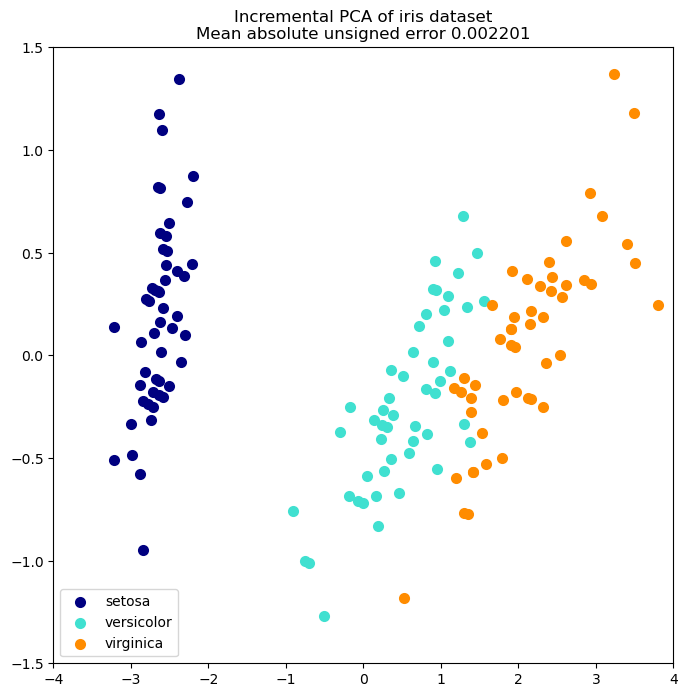

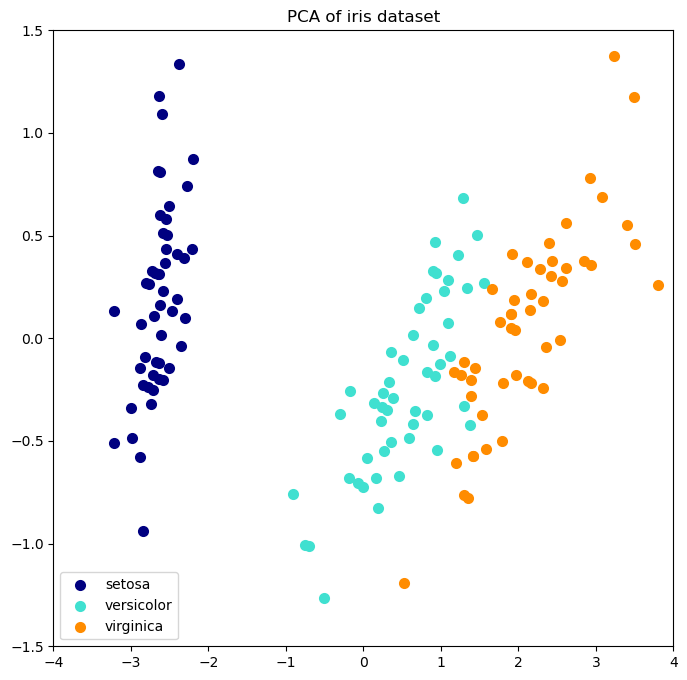

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


X, y = datasets.load_iris(return_X_y=True)

# 要壓縮到幾維的資料
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
X_ipca = ipca.fit_transform(X)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

colors = ["navy", "turquoise", "darkorange"]

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], ['setosa', 'versicolor', 'virginica']):
        plt.scatter(
            X_transformed[y == i, 0],
            X_transformed[y == i, 1],
            color=color,
            lw=2,
            label=target_name,
        )

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error %.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()



上面就是把燕尾花資料集投影到2維的資料的樣子，
降維手法也常被拿來做資料的前處理，
下面是使用的例子。



In [2]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR



X, y = datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87) 

model_linear = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_pred = model_linear.predict(X_test)

print("linear Model Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

regression_decision_tree = DecisionTreeRegressor(criterion='squared_error', 
                                                  min_samples_split=20).fit(X_train, y_train)

y_pred = regression_decision_tree.predict(X_test)


model_linearSVR = LinearSVR(C=1, random_state=87, tol=1e-5).fit(X_train, y_train)
y_pred = model_linearSVR.predict(X_test)
print("linear SVR Model Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

model_SVR = SVR(kernel='rbf', C=1, tol=1e-5).fit(X_train, y_train)
y_pred = model_SVR.predict(X_test)
print("SVR Model Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))


regression_decision_tree = DecisionTreeRegressor(criterion='squared_error', 
                                                  min_samples_split=20).fit(X_train, y_train)

y_pred = regression_decision_tree.predict(X_test)
print("Decision Tree Test Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

regression_random_forest = RandomForestRegressor(criterion='squared_error', 
                                                min_samples_split=20).fit(X_train, y_train)

y_pred = regression_random_forest.predict(X_test)

print("Random Forest Test Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

regression_extra_tree = ExtraTreesRegressor(criterion='squared_error',  
                                            min_samples_split=20).fit(X_train, y_train)
y_pred = regression_extra_tree.predict(X_test)

print("ExtraTrees Test Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

for i in range(9, 0, -1):
    print("\t PCA with %s components." % i)
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=87) 

    model_linear = LinearRegression(fit_intercept=True).fit(X_train, y_train)
    y_pred = model_linear.predict(X_test)
    print("linear Model Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

    model_linearSVR = LinearSVR(C=1, random_state=87, tol=1e-5).fit(X_train, y_train)
    y_pred = model_linearSVR.predict(X_test)
    print("linear SVR Model Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

    model_SVR = SVR(kernel='rbf', C=1, tol=1e-5).fit(X_train, y_train)
    y_pred = model_SVR.predict(X_test)
    print("SVR Model Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

    regression_random_forest = RandomForestRegressor(criterion='squared_error', 
                                                min_samples_split=20).fit(X_train, y_train)

    y_pred = regression_random_forest.predict(X_test)

    print("Random Forest Test Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))

    regression_extra_tree = ExtraTreesRegressor(criterion='squared_error',  
                                            min_samples_split=20).fit(X_train, y_train)
    y_pred = regression_extra_tree.predict(X_test)

    print("ExtraTrees Test Explained Variance Score: %.2f" % explained_variance_score(y_test, y_pred))



linear Model Explained Variance Score: 0.52
linear SVR Model Explained Variance Score: 0.02
SVR Model Explained Variance Score: 0.20
Decision Tree Test Explained Variance Score: -0.02
Random Forest Test Explained Variance Score: 0.45
ExtraTrees Test Explained Variance Score: 0.46
	 PCA with 9 components.
linear Model Explained Variance Score: 0.52
linear SVR Model Explained Variance Score: 0.02
SVR Model Explained Variance Score: 0.20
Random Forest Test Explained Variance Score: 0.49
ExtraTrees Test Explained Variance Score: 0.50
	 PCA with 8 components.
linear Model Explained Variance Score: 0.52
linear SVR Model Explained Variance Score: 0.02
SVR Model Explained Variance Score: 0.20
Random Forest Test Explained Variance Score: 0.50
ExtraTrees Test Explained Variance Score: 0.51
	 PCA with 7 components.
linear Model Explained Variance Score: 0.53
linear SVR Model Explained Variance Score: 0.02
SVR Model Explained Variance Score: 0.21
Random Forest Test Explained Variance Score: 0.51
E